# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
import networkx as nx

In [2]:
nx.__version__ # should be 2.1

'2.1'

In [3]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue


%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = 12, 12

## Step 1 - Load Data

In [25]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [106]:
teste = open(filename).readline().replace(',','')
l = []
for t in teste.split():
    try:
        l.append(float(t))
    except ValueError:
        pass
lat0, lon0 = l
print(lat0, lon0)

37.79248 -122.39745


## Step 2 - Sample Points


You may want to limit the z-axis values.

In [691]:
def sample_points(data, num_samples):
    xmin = np.min(data[:, 0] - data[:, 3])
    xmax = np.max(data[:, 0] + data[:, 3])

    ymin = np.min(data[:, 1] - data[:, 4])
    ymax = np.max(data[:, 1] + data[:, 4])

    zmin = 0
    zmax = 10

    xvals = np.random.uniform(xmin, xmax, num_samples)
    yvals = np.random.uniform(ymin, ymax, num_samples)
    zvals = np.random.uniform(zmin, zmax, num_samples)

    samples = list(zip(xvals, yvals, zvals))

    print("X\nMin = {0}, Max = {1}\n".format(xmin, xmax))
    print("Y\nMin = {0}, Max = {1}\n".format(ymin, ymax))
    print("Z\nMin = {0}, Max = {1}".format(zmin, zmax))
    
    return samples

In [692]:
num_samples = 600
samples = sample_points(data, num_samples)

X
Min = -315.2389, Max = 604.7611

Y
Min = -444.2315, Max = 475.7685

Z
Min = 0, Max = 10


In [693]:
def extract_polygons(data, safety_distance):
    
    polygons = []
    for i in range(data.shape[0]):
        
        #Carregar os pontos do arquivo
        north, east, alt, d_north, d_east, d_alt = data[i, :]

        #Extremidades do polígono
        Np = np.ceil(north + d_north + safety_distance)
        Nn = np.ceil(north - d_north - safety_distance)
        Ep = np.ceil(east + d_east + safety_distance)
        En = np.ceil(east - d_east - safety_distance)

        corners = [(Nn, En), (Nn, Ep), (Np, Ep), (Np, En)]

        #Altura do polígono
        height = np.ceil(alt + d_alt + safety_distance)
        
        #Gera um polígono a partir das quinas
        p = Polygon(corners)
        #Armazena o centro do polígono
        center = (north, east)
        #Adiciona a Polygons um tuple contendo o polígono p, a altura e o centro
        polygons.append((p, height, center))

    return polygons
    

In [694]:
safety_distance = 3
polygons = extract_polygons(data, safety_distance)
#polygons
#len(polygons)

In [695]:
from sklearn.neighbors import KDTree

def collides(polygons, point, pol_center):
    
    #Gera uma árvore a partir da lista de centros dos polígonos, com leafsize = 400
    tree = KDTree(pol_center, 400)
    
    #Faz uma pesquisa para encontrar o valor da árvore mais próximo ao PONTO inserido.
    #Retorna o índice do polígono mais próximo
    dist, ind = tree.query([point], k = 1)

    #xy é o ponto em estudo e z é a altura dele
    xy = Point(point[:2])
    z = point[2]
    
    #Discretiza os valores do tuple do polígono mais próximo
    p, height, center = polygons[int(ind)]
    
    #Se polígono contém o ponto em sua área e altura, existe colisão
    if p.contains(xy) and z <= height:
        return True
    else:
        return False   

In [696]:
to_keep = []
pol_centers = []

for p in polygons:
    pol_centers.append((p[2] + (0,)))

for i in samples:
    if not collides(polygons, i, pol_centers):
        to_keep.append(i)
    
len(to_keep)

310

## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [697]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!

In [698]:
def can_connect(node1, node2, max_dist, pol_centers):
    
    tree = KDTree(pol_centers, 1000)
    
    line = LineString([node1, node2])

    inds = tree.query_radius([node1], max_dist, count_only = False)
    near_pol = []
    
    if len(inds[0]) > 0:
        for i in range(0, len(inds[0])):
            #print(len(inds[0]))
            near_pol.append(polygons[inds[0][i]])
    
        for pol in near_pol:
            p, height, center = pol
            if p.crosses(line) and height >= min(node1[2], node2[2]):
                return False
    return True
    

In [699]:
def create_graph(points, k, pol_centers):
    g = nx.Graph()

    tree = KDTree(np.array(points), 1000)

    for p in points:
        dist, inds = tree.query([p], k+1)
        #print(inds, np.array(dist))
        
        for i in range(1, k+1):
            p2 = points[inds[0][i]]
            if can_connect(p, p2, dist[0][k], pol_centers):
                dist_peso = LA.norm(np.array(p) - np.array(p2))
                g.add_edge(p, p2, weight=dist_peso)

    return g
    

In [700]:
import time
t0 = time.time()
g = create_graph(to_keep, 7, pol_centers)
print('graph took {0} seconds to build'.format(time.time()-t0))
len(g.nodes)

graph took 4.695981502532959 seconds to build


279

## Step 4 - Visualize Graph

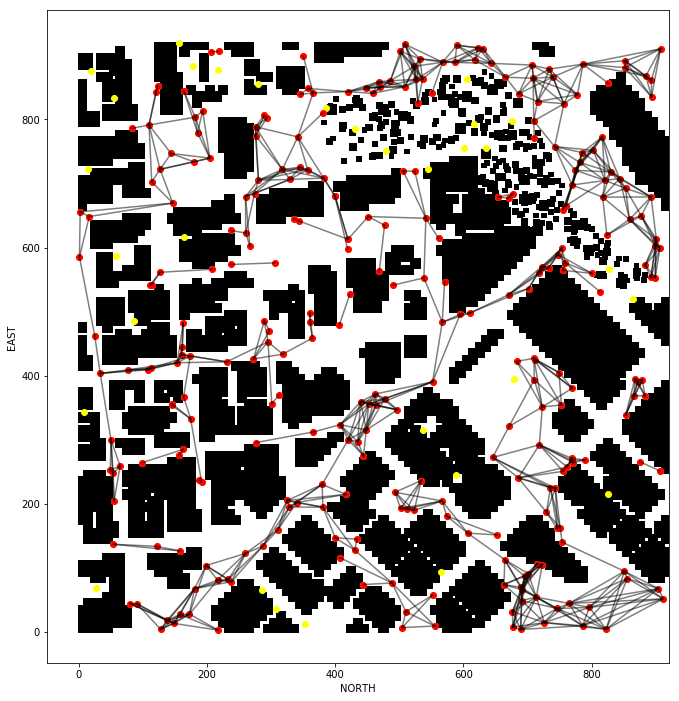

In [625]:
# Create a grid map of the world
from grid import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, 10, safety_distance)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0] - data[:, 3])

emin = np.min(data[:, 1] - data[:, 4])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

for n1 in to_keep:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='yellow')

# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 5 - Define Heuristic

In [626]:
def heuristic(n1, n2):
    return LA.norm(np.array(n1) - np.array(n2))

## Step 6 - Complete A*

In [634]:
from queue import PriorityQueue

def a_star(graph, h, start, goal):
        
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)
    
    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:
            current_cost = branch[current_node][0]
        
        if current_node == goal:
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                branch_cost = current_cost + cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:
                    visited.add(next_node)
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))
    
    if found:
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************')
    return path[::-1], path_cost

In [635]:
def closest_point(p1, node):
    dist = 10000
    closest = None
    
    for n in node:
        dnorm = LA.norm(np.array(p1) - np.array(n))
        if dnorm < dist:
            dist = dnorm
            closest = n

    return closest
            

In [680]:
start_ne = (-200,  -200, 5.0)
goal_ne = (750., 370., 3.0)

start = closest_point(start_ne, g.nodes)
goal = closest_point(goal_ne, g.nodes)
#print(start, goal)

path, cost = a_star(g, heuristic, start, goal)
print(len(path))

26


In [681]:
from bresenham import bresenham
def prune_path_bres(path, grid, goal):
    
    pruned_path = [p for p in path]
    i = 0
    
    while i < len(pruned_path) - 2:
        p1 = pruned_path[i]
        p2 = pruned_path[i+2]
        k = 0
        
        cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        
        for c in cells:
            k += grid[c]
            
        if k > 0:
            i += 1
        else:
            pruned_path.remove(pruned_path[i+1])
        
    pruned_path.append(goal)
    
    return pruned_path    

In [682]:
pruned_path = prune_path_bres(path, grid, goal)
len(pruned_path)

24

## Step 7 - Visualize Path

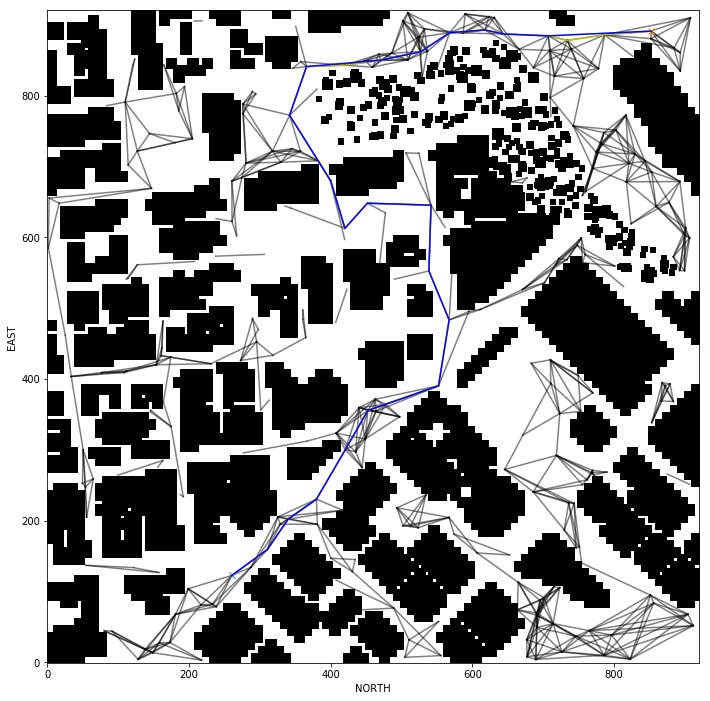

In [683]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')


nmin = np.min(data[:, 0] - data[:, 3])

emin = np.min(data[:, 1] - data[:, 4])

for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)
#for n1 in g.nodes:
    #plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')

plt.plot(start[1] - emin, start[0] - nmin, 'x')
plt.plot(goal[1] - emin, goal[0] - nmin, 'x')
              
pp = np.array(path)
plt.plot(pp[:,1] - emin , pp[:,0] - nmin, 'y')

pp = np.array(pruned_path)
plt.plot(pp[:,1] - emin , pp[:,0] - nmin, 'b')

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

[solution](/notebooks/Probabilistic-Roadmap-Solution.ipynb)